# Модуль решения СДУ

## Реализация
Цель задания -- реализация метода решения задачи Коши системы из нескольких дифференциальных уравнений на отрезке $[0, T]$. Затем протестируем его на СДУ из 2 уравнений с известным аналитическим решением, оценим погрешность.

### Описание алгоритма
Будем использовать стандартный метод Рунге-Кутты порядка 4 решения СДУ с известным начальным решением. В начале имеем систему:
$$
\left\{
\begin{aligned}
x' &= f(t, x)\\
x_0 &= x(0)
\end{aligned}
\right.
$$
где $t\in\mathbb{R}$, $x=(x_1(t), \dots, x_n(t))$, $f(t, x)=(f_1(t, x), \dots, f_n(t, x))$

Сначала разобъем отрезок $[0, T]$ на $N$ частей с шагом $h=T/N$. Затем начинаем итеративно вычислять значение вектор-функции $x$ на концах отрезков разбиения:
$$
\left\{
\begin{aligned}
k_1&=h\cdot f\left(t_k, x_k\right)\\
k_2&=h\cdot f\left(t_k+\frac{h}{2}, x_k+\frac{k_1}{2}\right)\\
k_3&=h\cdot f\left(t_k+\frac{h}{2}, x_k+\frac{k_2}{2}\right)\\
k_4&=h\cdot f\left(t_k+h, x_k+k_3\right)\\
x_{k+1}&=x_k+\frac{1}{6}(k_1+2k_2+2k_3+k_4)\\
t_{k+1}&=t_k+h
\end{aligned}
\right.
$$

Здесь векторы $k_i$ являются вкладами в новый вектор, основанный на поведении функции в начале середине и конце отрезка $[t_k, t_{k+1}]$.

В итоге получили вектор-функцию в сеточном представлении на отрезке $[0, T]$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def rk4(t0, x0, funcs, N, h):
    t = t0
    x = x0.copy()
    xs = np.zeros((N + 1, x.size))
    xs[0] = x
    for i in range(1, N + 1):
        k1 = h * np.array([ f(t, x) for f in funcs ])
        k2 = h * np.array([ f(t + h / 2, x + k1 / 2) for f in funcs ])
        k3 = h * np.array([ f(t + h / 2, x + k2 / 2) for f in funcs ])
        k4 = h * np.array([ f(t + h, x + k3) for f in funcs ])
        x += 1 / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        t += h
        xs[i] = x
    return xs


## Тестирование
Возьмем следующую задачу Коши:
$$
\left\{
\begin{aligned}
x' &= x-y\\
y' &= x+y\\
x(0) & = 0, \ 
y(0) = -1
\end{aligned}
\right.
$$

Сначала формально покажем, что решение такой системы существует и единственно. Для этого применим соответствующую теорему, которая для выполнимости этих свойств требует липцицевости компонент вектор-функции $f$:


$$f_i: \mathbb{R}^3\to\mathbb{R}$$

$$\exists K\in\mathbb{R} : \forall (t, \textbf{x}_a), (t, \textbf{x}_b)\in\mathbb{R}^3 : \ \lVert f_i(a, \textbf{x}_a) - f_i(b, \textbf{x}_b)\rVert_{\mathbb{R}}\leqslant K\cdot\lVert \textbf{x}_a - \textbf{x}_b \rVert_{\mathbb{R}^2} $$

В качестве $\lVert\cdot\rVert_{\mathbb{R}}$ берем просто модуль, а в качестве $\lVert\cdot\rVert_{\mathbb{R^2}}$ -- $\ell_1$ норму. Тогда имеем систему неравенств:

$$
\left\{
\begin{aligned}
|x_a-y_a-x_b+y_b|\leqslant K_1\cdot(|x_a - x_b| + |y_a - y_b|)\\
|x_a+y_a-x_b-y_b|\leqslant K_2\cdot(|x_a - x_b| + |y_a - y_b|)\\
\end{aligned}
\right.
\Leftrightarrow
\left\{
\begin{aligned}
|(x_a-x_b)-(y_a-y_b)|\leqslant K_1\cdot(|x_a - x_b| + |y_a - y_b|)\\
|(x_a-x_b)+(y_a-y_b)|\leqslant K_2\cdot(|x_a - x_b| + |y_a - y_b|)\\
\end{aligned}
\right.
$$

Подставим $K_1=K_2=1$, получим истинное неравенство треугольника. Значит функции липшицевы, и решение существует и единственно.

Вернемся к алгоритму. Будем работать с отрезком $[0, 10]$. 

Общее решения данной системы имеет вид:
$$
\left\{
\begin{aligned}
x(t) &= C_1e^t\cos{t}-C_2e^t\sin{t}\\
y(t) &= C_1e^t\sin{t}+C_2e^t\cos{t}
\end{aligned}
\right.
$$

Подставлям частные решения, получим:
$$
\left\{
\begin{aligned}
x(t) &= e^t\sin{t}\\
y(t) &= -e^t\cos{t}
\end{aligned}
\right.
$$

Затем нарисуем векторное поле правой части $f(t, \mathbf{x})$, построим оригинальные и вычисленные решения СДУ, рассмотрим зависимость Чебышевской нормы ошибки приближения по всем отрезкам от размера шага.

In [3]:
def f1(t, x):
    return x[0] - x[1]

def f2(t, x):
    return x[0] + x[1]

def x_real(t):
    return np.exp(t) * np.sin(t)

def y_real(t):
    return -np.exp(t) * np.cos(t)


In [4]:
t0 = 0
T = 10
N = 100
h = T / N
grid = np.linspace(t0, T, N + 1)
grid_test = np.linspace(t0, T, 1000 + 1)
funcs = [ f1, f2 ]
x0 = np.array([0., -1.])


xs = rk4(t0, x0, funcs, N, h)

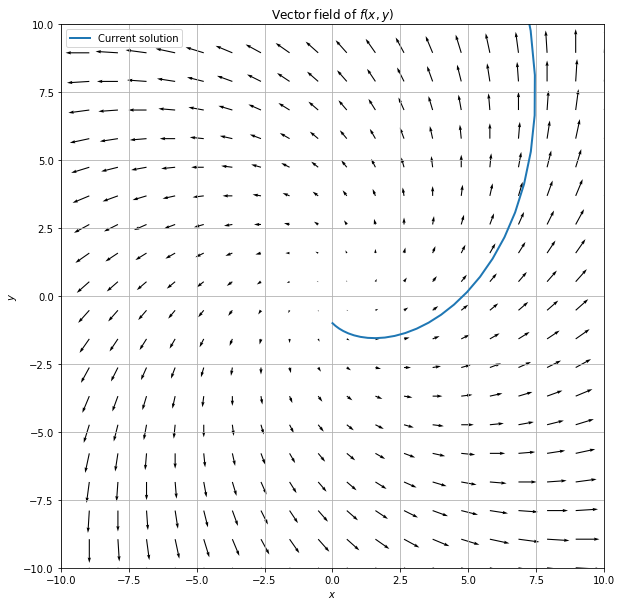

In [5]:
plt.figure(figsize=(10, 10))
x = np.linspace(-10, 10, 20)
y = np.linspace(-10, 10, 20)
X, Y = np.meshgrid(x, y)
u = X - Y
v = X + Y
plt.quiver(X, Y, u, v, width=0.002)
x0 = np.array([0., -1])
xs = rk4(t0, x0, funcs, N, h)
plt.plot(xs[:, 0], xs[:, 1], linewidth=2, label='Current solution')
plt.grid(True)
plt.title(r"Vector field of $f(x, y)$")
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.axis('scaled')
plt.xlim((-10, 10))
plt.ylim((-10, 10))
plt.legend()
plt.show()

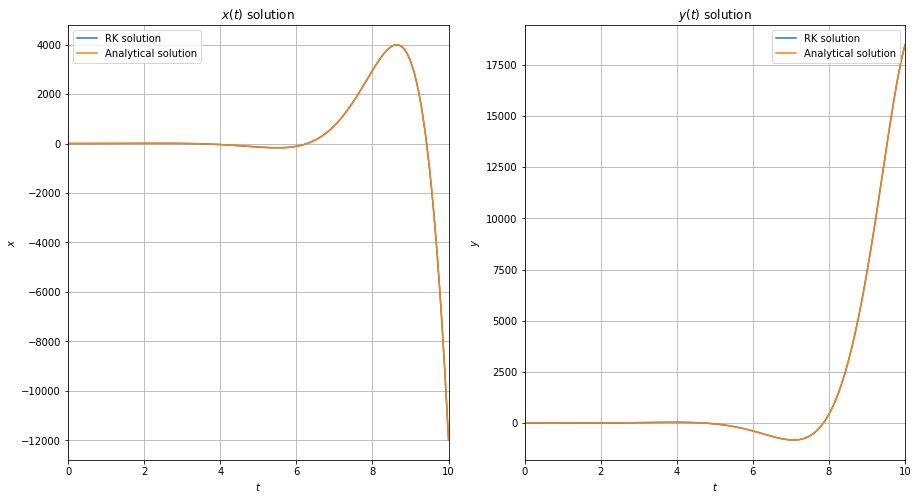

In [6]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.title(r'$x(t)$ solution')
plt.plot(grid, xs[:, 0], label=f'RK solution')
plt.plot(grid_test, x_real(grid_test), label=f'Analytical solution')
plt.grid(True)
plt.xlabel(r'$t$')
plt.ylabel(r'$x$')
plt.xlim((0, 10))
plt.legend()

plt.subplot(1, 2, 2)
plt.title(r'$y(t)$ solution')
plt.plot(grid, xs[:, 1], label=f'RK solution')
plt.plot(grid_test, y_real(grid_test), label=f'Analytical solution')
plt.grid(True)
plt.xlabel(r'$t$')
plt.ylabel(r'$y$')
plt.xlim((0, 10))
plt.legend()
plt.show()

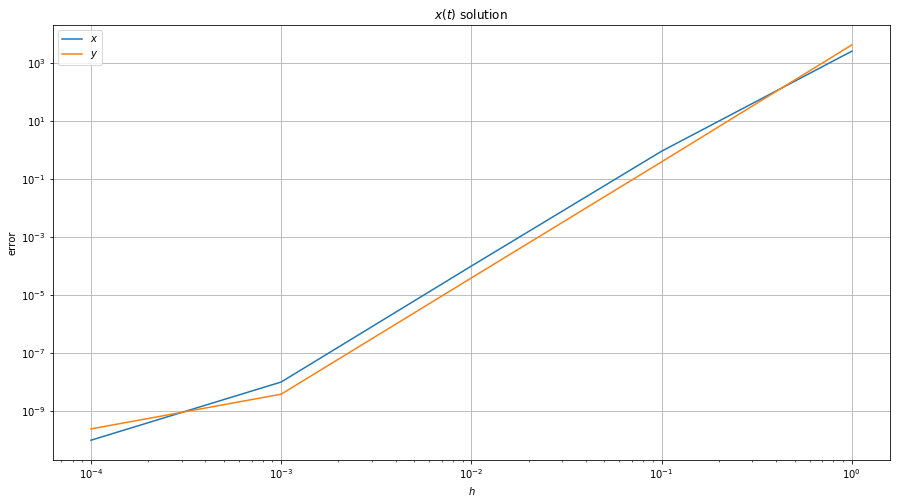

In [7]:
Ns = [ 10 ** k for k in range(1, 6)]

t0 = 0
T = 10
funcs = [ f1, f2 ]
x0 = np.array([0., -1.])

hs, x_err, y_err = [], [], []

for N in Ns:
    h = T / N
    grid = np.linspace(t0, T, N + 1)
    xs = rk4(t0, x0, funcs, N, h)
    hs.append(h)
    x_err.append(np.max(np.abs(xs[:, 0] - x_real(grid))))
    y_err.append(np.max(np.abs(xs[:, 1] - y_real(grid))))
    
plt.figure(figsize=(15, 8))

plt.title(r'$x(t)$ solution')
plt.plot(hs, x_err, label=r'$x$')
plt.plot(hs, y_err, label=r'$y$')
plt.grid(True)
plt.xlabel(r'$h$')
plt.ylabel(r'error')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

Можно наблюдать, что точность метода действительно составляет $O(h^4)$ на одном шаге (наша метрика измеряет максимум ошибки на одном шаге) и ошибка ведет себя практически одинаково на обеих функциях.